In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('riverside_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,91752,Riverside County,1,2015,Residential,4963281.0,4.963281
1,91752,Riverside County,1,2015,Commercial,8793113.0,8.793113
2,91752,Riverside County,1,2015,Agricultural,1297229.0,1.297229
3,92210,Riverside County,1,2015,Residential,5709384.0,5.709384
4,92210,Riverside County,1,2015,Commercial,2528103.0,2.528103


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15369 entries, 0 to 15368
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        15369 non-null  int64  
 1   County         15369 non-null  object 
 2   Month          15369 non-null  int64  
 3   Year           15369 non-null  int64  
 4   CustomerClass  15369 non-null  object 
 5   TotalkWh       15369 non-null  float64
 6   TotalGWh       15369 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 840.6+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15369 entries, 0 to 15368
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        15369 non-null  int64         
 1   County         15369 non-null  object        
 2   Month          15369 non-null  int64         
 3   Year           15369 non-null  int64         
 4   CustomerClass  15369 non-null  object        
 5   TotalkWh       15369 non-null  float64       
 6   TotalGWh       15369 non-null  float64       
 7   Date           15369 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 960.7+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,91752,Riverside County,1,2015,Residential,4963281.0,4.963281
2015-01-01,91752,Riverside County,1,2015,Commercial,8793113.0,8.793113
2015-01-01,91752,Riverside County,1,2015,Agricultural,1297229.0,1.297229
2015-01-01,92210,Riverside County,1,2015,Residential,5709384.0,5.709384
2015-01-01,92210,Riverside County,1,2015,Commercial,2528103.0,2.528103


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,799830236.0,799.830236
2015-02-28,639725194.0,639.725194
2015-03-31,741633532.0,741.633532
2015-04-30,698376897.0,698.376897
2015-05-31,684099694.0,684.099694


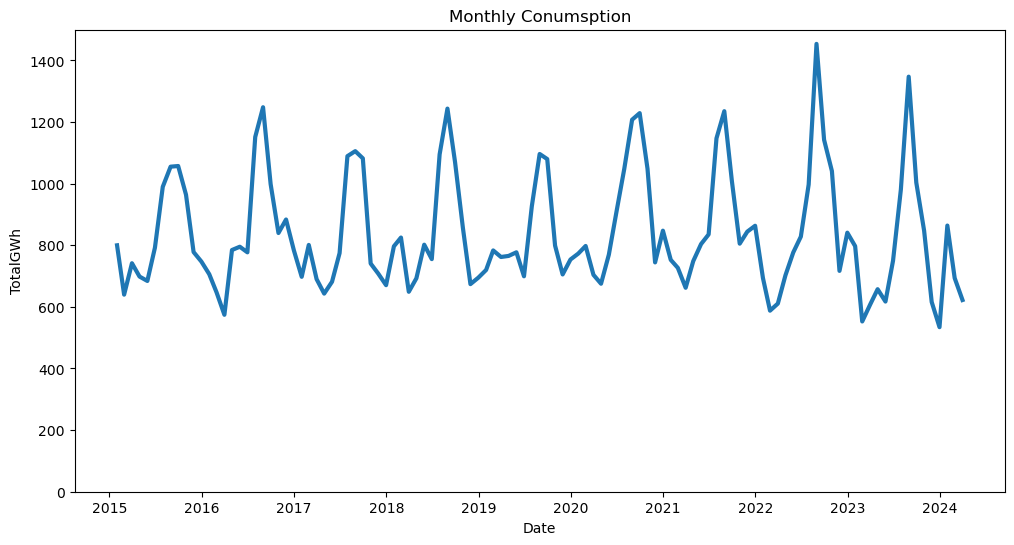

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -2.213766767112292
p-value: 0.20128690999309862
Non-Stationary


***SARIMAX model can still handle non-stationary data***

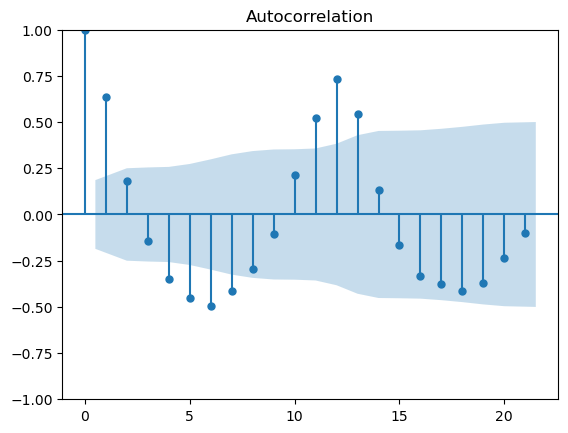

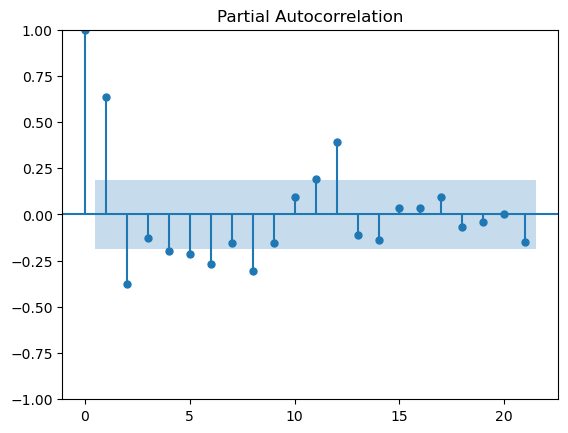

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1431.335, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1379.972, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1406.097, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1429.347, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1431.494, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1370.449, Time=0.75 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1366.329, Time=0.53 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1406.192, Time=0.20 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1387.392, Time=0.70 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1373.609, Time=0.42 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

In [18]:
# p, d, q parameters
model.order

(3, 1, 0)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

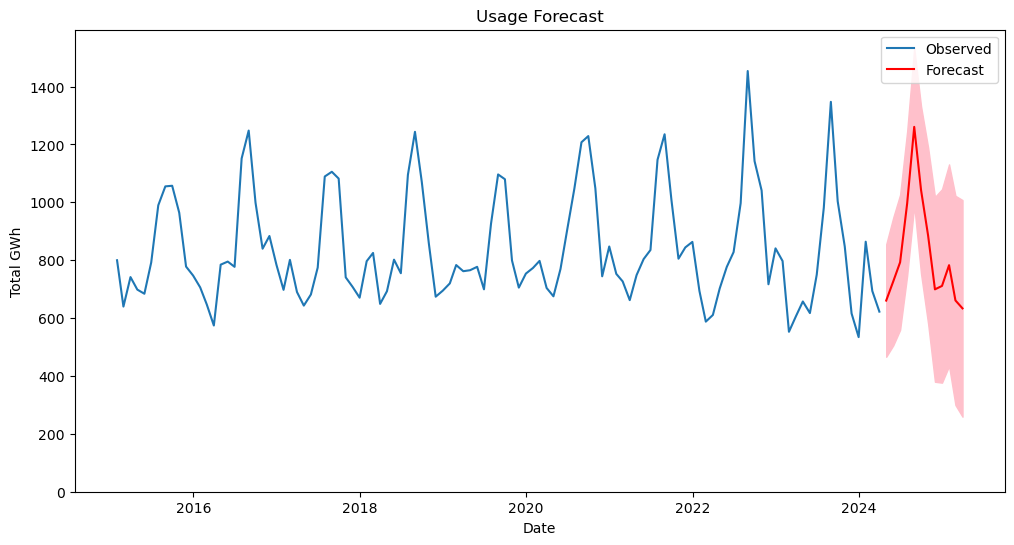

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

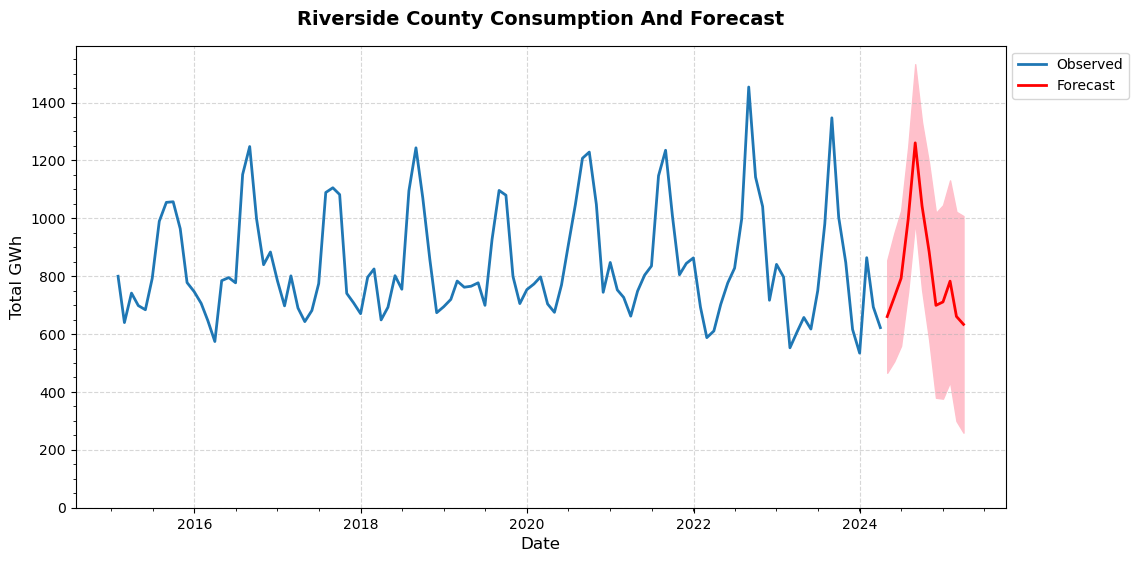

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Riverside County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.14,1), loc='upper right')

# Show plot
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 59.880297561904406
MSE: 5872.859320630615
RMSE: 76.63458305902509


In [24]:
observed

Date
2023-04-30     657.349916
2023-05-31     617.292532
2023-06-30     749.839544
2023-07-31     981.095894
2023-08-31    1347.201646
2023-09-30    1003.617532
2023-10-31     847.385560
2023-11-30     615.917207
2023-12-31     534.173978
2024-01-31     863.931974
2024-02-29     693.535099
2024-03-31     622.249126
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2024-04-30     660.495631
2024-05-31     726.808527
2024-06-30     792.701343
2024-07-31     996.113384
2024-08-31    1260.693467
2024-09-30    1042.313417
2024-10-31     884.943022
2024-11-30     699.269533
2024-12-31     711.086383
2025-01-31     782.804273
2025-02-28     660.950346
2025-03-31     633.532985
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

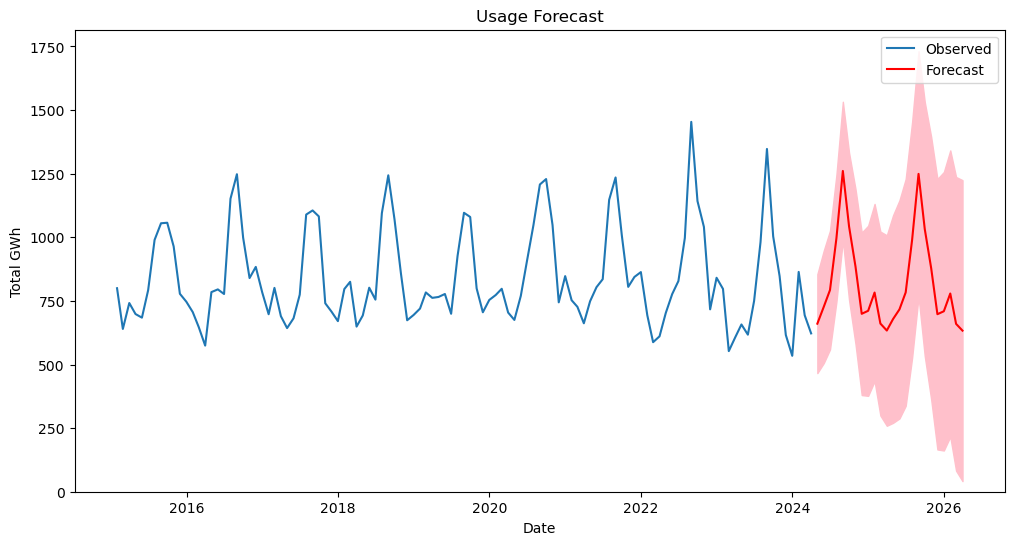

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 65.85131118456394
MSE: 7314.894756729404
RMSE: 85.5271580068542


In [28]:
observed

Date
2022-04-30     702.333166
2022-05-31     776.743547
2022-06-30     828.049085
2022-07-31     997.181298
2022-08-31    1453.647226
2022-09-30    1142.340855
2022-10-31    1040.812046
2022-11-30     716.864859
2022-12-31     840.877780
2023-01-31     797.102347
2023-02-28     552.600661
2023-03-31     606.889661
2023-04-30     657.349916
2023-05-31     617.292532
2023-06-30     749.839544
2023-07-31     981.095894
2023-08-31    1347.201646
2023-09-30    1003.617532
2023-10-31     847.385560
2023-11-30     615.917207
2023-12-31     534.173978
2024-01-31     863.931974
2024-02-29     693.535099
2024-03-31     622.249126
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2024-04-30     660.495631
2024-05-31     726.808527
2024-06-30     792.701343
2024-07-31     996.113384
2024-08-31    1260.693467
2024-09-30    1042.313417
2024-10-31     884.943022
2024-11-30     699.269533
2024-12-31     711.086383
2025-01-31     782.804273
2025-02-28     660.950346
2025-03-31     633.532985
2025-04-30     678.493429
2025-05-31     716.722270
2025-06-30     783.359871
2025-07-31     989.864289
2025-08-31    1249.180835
2025-09-30    1032.200840
2025-10-31     878.269159
2025-11-30     697.668001
2025-12-31     709.270461
2026-01-31     779.022696
2026-02-28     659.772059
2026-03-31     633.095071
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural     4430.588148
Commercial      26212.660198
Industrial      17424.789988
Residential     44839.568916
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,4430.588148
1,Commercial,26212.660198
2,Industrial,17424.789988
3,Residential,44839.568916


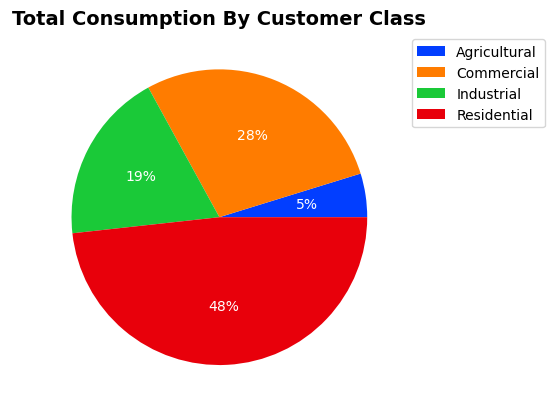

In [32]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

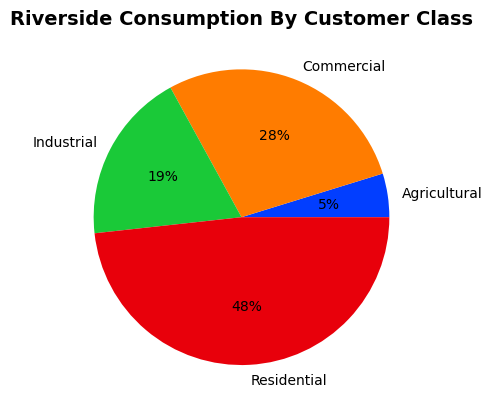

In [33]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Riverside Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

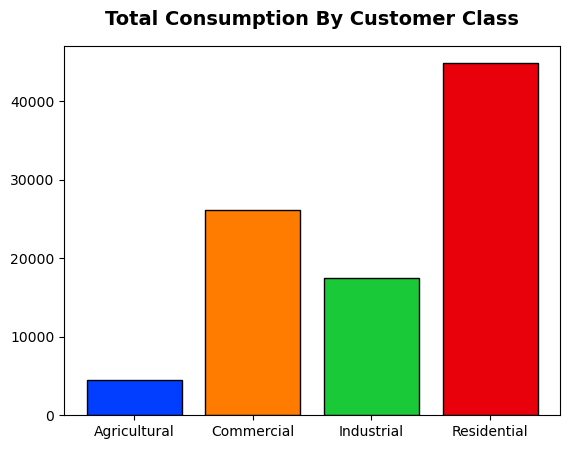

In [34]:
# Bar chart
plt.bar(customer_df['CustomerClass'],customer_df['TotalGWh'], color=palette_color,edgecolor='black', )
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center', pad=15)
plt.show()